### Outline
------------------------

1) Introdução
2) Metodologia
   * Descrição dos procedimentos
3) Análise Descritiva e Limpeza    
    - Histogramas
    - Normalizacao 
4) Modelagem
    * Redução de dimensionalidade
        * PCA 
        * UMAP
    * Clusterização
        * KMeans
        * DBSCAN
        * GMM
    * Classificação 
        * glmnet
        * Random Forest
------------------------------------------------------------------------
5) Resultados e conclusões


# Introdução


Uma grande multinacional varejista do ramo de supermercados deseja ingressar no mercado brasileiro. Você é o responsável pela análise que servirá de base para a estratégia (tomada de decisão) de entrada dessa empresa no Brasil. 
Elabore uma apresentação para os investidores desta empresa buscando realizar as seguintes tarefas:

  *  **Realize uma classificação dos municípios brasileiros com base nas informações disponíveis e faça uma caracterização dos municípios em grupos.**
 
 *  **Elabore uma forma de classificar um novo município entre os grupos já criados na etapa anterior**
 
 * **Responda em sua apresentação quais grupos de municípios deveriam ser a porta de entrada para empresa no país e porque.**

In [2]:
import os
import pandas as pd
import numpy as np
import scipy

import sklearn as sk
import shap
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
import seaborn

os.getcwd()

'/projects'

# 1 - Aplicação

In [3]:
## leitura do dataset
diretorio = "/projects/data/raw/dados_municipais.csv"
dados_municipais = pd.read_csv(diretorio, sep = ",")

-----------------------------------

## 1.1 - Análise descritiva e limpeza dos dados

#### Antes de começarmos a modelagem dos dados, devemos selecionar somente as columas numéricas que representam as nossas variáveis onde queremos realizar a clusterização das observações. Como as variáveis estão em diferentes escalas, e iremos utilizar técnicas de redução de dimensionalidade que sao baseados em KNN, é de grande ajuda converter as features em z-scores ou normalizá-las em seu range (minmax)

In [5]:
## Selecionando somente as colunas numéricas
columns = [ 
	   'Densidade_demográfica_2000', 'Distância_à_capital_km_',
       'Esperança_de_vida_ao_nascer_2000',
       'Mortalidade_até_um_ano_de_idade_2000',
       'Taxa_de_fecundidade_total_2000',
       'Percentual_de_pessoas_de_25_anos_ou_mais_analfabetas_2000',
       'Renda_per_Capita_2000', 'Índice_de_Gini_2000',
       'Intensidade_da_indigência_2000', 'Intensidade_da_pobreza_2000',
       'Índice_de_Desenvolvimento_Humano_Municipal_2000',
       'Taxa_bruta_de_freqüência_à_escola_2000', 'Taxa_de_alfabetização_2000',
       'Média_de_anos_de_estudo_das_pessoas_de_25_anos_ou_mais_de_idade_2000',
       'População_de_25_anos_ou_mais_de_idade_1991',
       'População_de_25_anos_ou_mais_de_idade_2000',
       'População_de_65_anos_ou_mais_de_idade_1991',
       'População_de_65_anos_ou_mais_de_idade_2000', 'População_total_1991',
       'População_total_2000', 'População_urbana_2000',
       'População_rural_2000'
    ]

dados_municipais_numericFeatures = dados_municipais[columns].values
dados_municipais_numericFeatures.shape

## normalizacao
scale = sk.preprocessing.MinMaxScaler()
minmax = scale.fit_transform(dados_municipais_numericFeatures)
df_std = pd.DataFrame(minmax)
df_std.columns = columns


------------------------------------------

### 1.1.1 - Análise Exploratória

#### A seguinte tabela mostra as estatisticas descritivas das variáveis numéricas do dataset.


In [6]:
## estatisticas descritivas do dataset
print(df_std.shape)
#dados_municipais.describe().transpose()
df_std.describe().transpose()


(5360, 22)


,count,mean,std,min,25%,50%,75%,max
Densidade_demográfica_2000,5360.0,0.007417,0.040881,0.0,0.000869,0.001824,0.003689,1.0
Distância_à_capital_km_,5360.0,0.171785,0.110823,0.0,0.082624,0.154661,0.242701,1.0
Esperança_de_vida_ao_nascer_2000,5360.0,0.561566,0.203722,0.0,0.426353,0.582459,0.715904,1.0
Mortalidade_até_um_ano_de_idade_2000,5360.0,0.275640,0.177007,0.0,0.128008,0.231374,0.391600,1.0
Taxa_de_fecundidade_total_2000,5360.0,0.209861,0.119769,0.0,0.123596,0.178170,0.268058,1.0
Percentual_de_pessoas_de_25_anos_ou_mais_analfabetas_2000,5360.0,0.361973,0.222020,0.0,0.175996,0.302682,0.554404,1.0
Renda_per_Capita_2000,5360.0,0.153251,0.103588,0.0,0.062606,0.140526,0.220017,1.0
Índice_de_Gini_2000,5360.0,0.437143,0.127735,0.0,0.347826,0.434783,0.521739,1.0
Intensidade_da_indigência_2000,5360.0,0.563686,0.119236,0.0,0.485056,0.560512,0.639052,1.0
Intensidade_da_pobreza_2000,5360.0,0.466455,0.159645,0.0,0.333841,0.454289,0.590159,1.0


#### Visualizando a distribuição das variáveis:

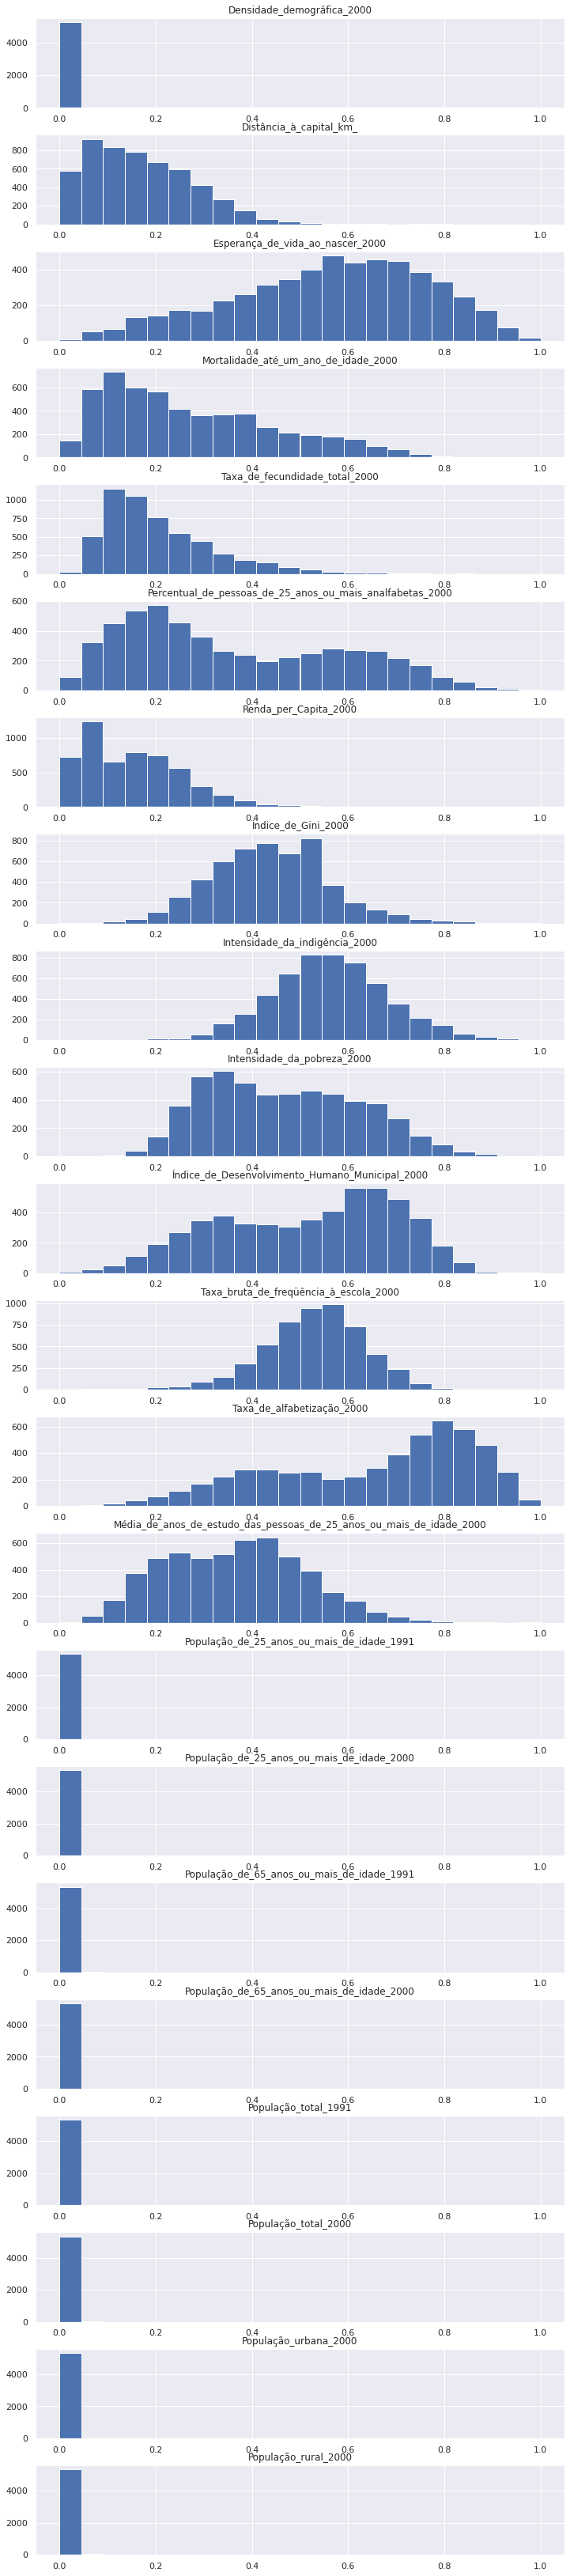

In [183]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
seaborn.set(style = "darkgrid")
fig, axes = plt.subplots(22, figsize = (12,59))
for i, j in zip(df_std.columns, range(0, 22)):
    df_std.hist("{0}".format(i), bins = 22 , ax = axes[j])

In [184]:
#Inserir aqui o motivo da escolha das variaveis 1:14

In [7]:
features_treino = df_std.columns[1:14]
df_treino = df_std[features_treino]

----------------------------------

## 1.2 - Modelagem

### 1.2.1 - Redução de dimensionalidade

No âmbido do big data, métodos de redução de dimensionalidade são ubíquos. Essas técnicas nos permitem visualizar e sumarizar os dados em espaços topológicos com dimensão inferior àquelas dos dados originais


#### UMAP


UMAP é um acrônimo para **Uniform Manifold Aproximation and Projection**. UMAP é utilizado como uma técnica de redução de dimensionalidade. Assim, quando temos um conjunto de dados com um número de variáveis elevado (k > 3), utiliza-se UMAP para projetar essas variáveis num espaço topológico de menor dimensão onde a estrutura original dos dados é preservada.


In [ ]:
#fig, axes =  plt.subplots(9, figsize = (15, 100))
for i, j in zip(itertools.product([100, 200, 300, 400, 500, 600], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), range(36)):
    redim = UMAP(n_neighbors = i[0], min_dist = i[1], n_components = 5)
    emb = redim.fit_transform(minmax)
    plt.scatter(emb[:,2], emb[:,4])

NameError: name 'itertools' is not defined

Após uma busca intensiva no espaço hiperparamétrico, encontramos que os melhores valores para os hiperparâmetros do UMAP foram:

 - n_neighbors = 25
 - min_dist = 0.1 
 - n_components = 2


In [125]:
umap = UMAP(n_neighbors = 25,  min_dist = 0.1, n_components = 2, metric = 'correlation')
UMAP_embedding = umap.fit_transform(df_treino)
#chebyshev performs better than mahalanobis
#correlation metric has performed better than chebyshev

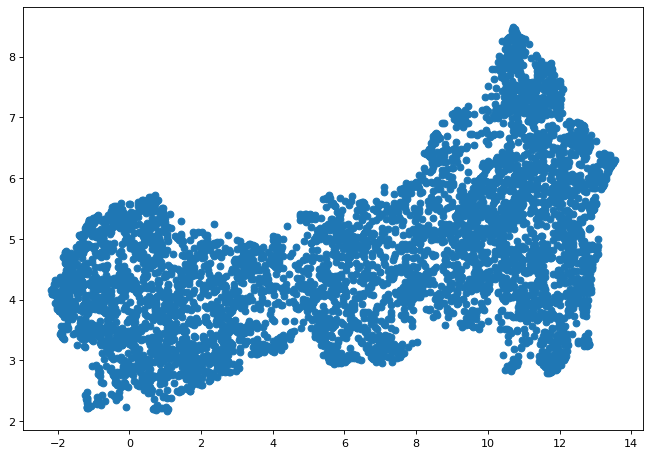

In [126]:
plt.figure(figsize=(10, 7), dpi=80)
plt.scatter(UMAP_embedding[:,0], UMAP_embedding[:,1])

In [175]:
UMAP_embedding

array([[ 9.882428 ,  4.082546 ],
       [10.729237 ,  6.709391 ],
       [ 8.507145 ,  4.257539 ],
       ...,
       [ 3.9982553,  3.2342284],
       [11.255504 ,  3.8844674],
       [ 1.6770359,  4.725299 ]], dtype=float32)

## Clusterização

In [467]:
kmeans_model = sk.cluster.KMeans(n_clusters=2)
fit = kmeans_model.fit_predict(embeddings)

In [486]:
classes = pd.DataFrame({"cluster": fit})
dados_municipais['cluster'] = classes['cluster']


### GMM 

#### O Mapa de calor a seguir mostra os pontos de maior densidade, indicando os possíveis clusters.

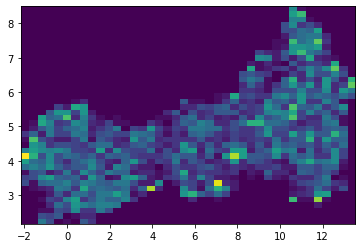

In [176]:
heatmap, xedges, yedges = np.histogram2d(df_c['emb0'], df_c['emb1'], bins=40)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower',aspect='auto')
plt.show()

#### Devido à anisotropia presente na projeção dos dados obtidos pelo processo de redução de dimensionalidade, temos indícios que um modelo gaussiano misto (GMM) possa ser adequado para realizar a clusterizacao dos municipios


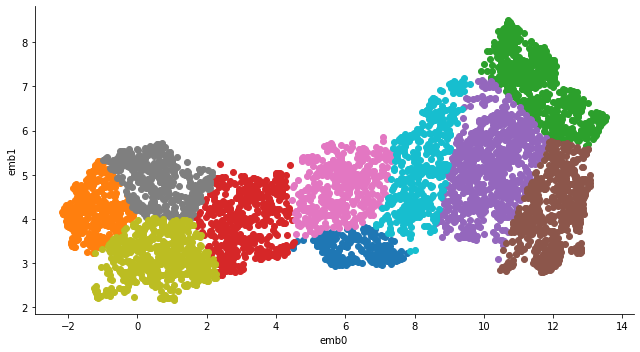

In [174]:
embedding = pd.DataFrame(UMAP_embedding)

gmm = GaussianMixture(n_components = 10, init_params = "kmeans", max_iter = 100, covariance_type = 'full' )

gmm = gmm.fit(embedding)

mixtures = pd.DataFrame({"model" : gmm.predict(embedding)})

df_c = pd.concat([embedding,  mixtures.reset_index(drop = True)], axis = 1)

df_c.columns = ['emb0','emb1',"model"]

#plotting clusters
fg = seaborn.FacetGrid(data=df_c, hue='model', aspect=1.8,height =5)

fg.map(plt.scatter, 'emb0',"emb1")

In [178]:
dados_clusterizados = pd.DataFrame(dados_municipais_numericFeatures)
dados_clusterizados.columns = columns
dados_clusterizados = pd.concat([dados_clusterizados, mixtures.reset_index(drop = True)], axis = 1)
dados_clusterizados.groupby(['model'])['model'].count()

model
0    251
1    440
2    710
3    527
4    835
5    620
6    441
7    431
8    598
9    507
Name: model, dtype: int64